In [1]:
import json
from argparse import ArgumentParser
import os
from pathlib import Path

import numpy as np
import pyvista as pv
import torch
from PIL import Image
from dreifus.camera import CameraCoordinateConvention, PoseType
from dreifus.image import Img
from dreifus.matrix import Pose, Intrinsics
from dreifus.pyvista import add_coordinate_axes, add_camera_frustum
from dreifus.trajectory import circle_around_axis
from dreifus.util.visualizer import ImageWindow
from dreifus.vector import Vec3
from gaussian_splatting.arguments import OptimizationParams, PipelineParams2
from gaussian_splatting.gaussian_renderer import render
from gaussian_splatting.scene import GaussianModel
from gaussian_splatting.scene.cameras import pose_to_rendercam
from gaussian_splatting.utils.graphics_utils import BasicPointCloud
from gaussian_splatting.utils.viewer import GaussianViewer
from mediapy import VideoWriter
from tqdm import tqdm
import time

if __name__ == '__main__':
    IMAGE_CONFIGURATION = 'full' 
    use_visualization_window = True
    use_viewer = True
    n_iterations = 10000
    downscale_factor = 2  # By how much to downscale the images

    # ==========================================================
    # Data
    # ==========================================================
    print(f'Running Gaussian Splatting for image configuration: {IMAGE_CONFIGURATION}')

    # Load camera poses and intrinsics
    camera_params = json.load(open('data/camera_params.json'))
    intrinsics = Intrinsics(camera_params['intrinsics'])  # Note: In the demo, all cameras have the same intrinsics
    intrinsics = intrinsics.rescale(1 / downscale_factor)  # Note: when images are rescaled, intrinsics has to be scaled as well!
    cam_2_world_poses = dict()  # serial => world_2_cam_pose
    for serial, cam_2_world_pose in camera_params['cam_2_world_poses'].items():
        cam_2_world_pose = Pose(cam_2_world_pose, camera_coordinate_convention=CameraCoordinateConvention.OPEN_CV, pose_type=PoseType.CAM_2_WORLD)
        cam_2_world_poses[serial] = cam_2_world_pose

    # Load images
    images = dict()  # serial => image
    serials = []
    for image_file in Path(f'data/{IMAGE_CONFIGURATION}').iterdir():
        serial = image_file.stem
        image = Image.open(image_file)
        image = image.resize((int(image.width / downscale_factor), int(image.height / downscale_factor)))  # Resize image
        image = np.array(image)
        images[serial] = image
        serials.append(serial)

    # ==========================================================
    # Visualize
    # ==========================================================

    # Visualize camera poses and images
    print('Visualize camera poses and images')
    pv.start_xvfb()
    p = pv.Plotter()
    add_coordinate_axes(p, scale=0.1)
    for serial in serials:
        add_camera_frustum(p, cam_2_world_poses[serial], intrinsics, image=images[serial])
    #p.show()

    # ==========================================================
    # Model
    # ==========================================================
    print('Model')
    # Setup 3D Gaussian Model and optimizer
    device = torch.device('cuda')
    gaussian_model = GaussianModel(sh_degree=0)
    bg_color = torch.ones(3, device=device, dtype=torch.float32)  # Use white background for rendering

    # Initialize some random 3D points
    pointcloud = BasicPointCloud(points=torch.randn((5000, 3)) / 20, colors=torch.randn((5000, 3)), normals=None)
    gaussian_model.create_from_pcd(pointcloud, spatial_lr_scale=1)
    
    # Setup optimizer
    parser = ArgumentParser()
    params_opt = OptimizationParams(parser)
    gaussian_model.training_setup(params_opt)
    optimizer = gaussian_model.optimizer

    # ==========================================================
    # Viewer
    # ==========================================================
    print('Viewer')
    # Setup interactive web-based 3D Viewer for 3D Gaussians
    if use_viewer:
        viewer_poses = [cam_2_world_poses[serial] for serial in serials]
        viewer_intrinsics = [intrinsics for _ in serials]
        viewer_images = [images[serial] for serial in serials]
        viewer = GaussianViewer(gaussian_model,
                                poses=viewer_poses,
                                intrinsics=viewer_intrinsics,
                                images=viewer_images,
                                size=0.03)
        viewer.server.set_up_direction("-y")

    image_buffer = None
    if use_visualization_window:
        image_buffer = np.zeros_like(images[serials[0]], dtype=np.float32)
        #image_window = ImageWindow(image_buffer)

    # ==========================================================
    # Optimization Loop
    # ==========================================================
    print('Optimization Loop')
    H, W, _ = images[serials[0]].shape
    torch_images = {serial: torch.tensor(image / 255, device=device).permute(2, 0, 1) for serial, image in images.items()}
    progress = tqdm(range(n_iterations))
    for iteration in progress:
        serial = serials[iteration % len(serials)]
        gt_image = torch_images[serial]
        cam_2_world_pose = cam_2_world_poses[serial]
        gs_camera = pose_to_rendercam(cam_2_world_pose, intrinsics, W, H)

        # Render current 3D reconstruction
        output = render(gs_camera, gaussian_model, PipelineParams2(), bg_color)
        rendered_image = output['render']

        # Compute L1 loss
        loss = (rendered_image - gt_image).abs().mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Gaussian Splatting Training tricks:
        #  1. Learning rate schedule for 3D positions (positions will receive smaller and small updates)
        gaussian_model.update_learning_rate(iteration)

        #  2. Adaptive density control:
        #       - Clone/Split Gaussians with high positional gradient (that move around a lot)
        #       - Prune Gaussians with low opacity (don't clutter scene)
        if (iteration + 1) % 100 == 0:
            gaussian_model.add_densification_stats(output['viewspace_points'],
                                                   output['visibility_filter'])  # Important, otherwise prune and densify don't work
            gaussian_model.densify_and_prune(0.0002, 0.005, 1, None)

        #  3. Opacity reset (needed such that Pruning is more effective)
        if (iteration + 1) % 3000 == 0:
            gaussian_model.reset_opacity()

        # Log prediction to visualization window
        if use_visualization_window and serial == '222200037':
            image_buffer[:] = rendered_image.permute(1, 2, 0).detach().cpu().numpy()

        progress.set_postfix({"loss": loss.item()})

Running Gaussian Splatting for image configuration: full
Visualize camera poses and images


/home/oroz/anaconda3/envs/gaussian_splatting/lib/python3.8/site-packages/pyvista/core/dataset.py:595: PyVistaDeprecationWarning: Use of `DataSet.active_t_coords` is deprecated. Use `DataSet.active_texture_coordinates` instead.
  warnings.warn(


Model
Number of points at initialisation :  5000
Viewer


╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:8015   │
│   Websocket │ ws://0.0.0.0:8015     │
│             ╵                       │
╰─────────────────────────────────────╯

/home/oroz/anaconda3/envs/gaussian_splatting/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/oroz/anaconda3/envs/gaussian_splatting/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Optimization Loop


  0%|          | 0/10000 [00:00<?, ?it/s]


BW IMPLEMENTATION: ORIGINAL (no optimization)
BALANCE_THRESHOLD: 8



100%|██████████| 10000/10000 [05:14<00:00, 31.83it/s, loss=0.00634]


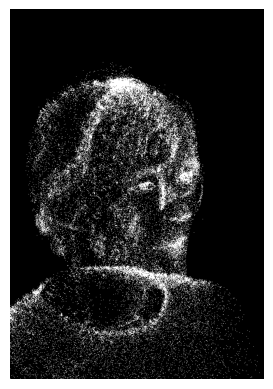

In [6]:
import matplotlib.pyplot as plt
import image_feature_projection as imfp
from importlib import reload
reload(imfp)

images = {key: value for key, value in images.items() if key in ['221501007', '222200037', '222200046']}
cam_2_world_poses = {key: value for key, value in cam_2_world_poses.items() if key in ['221501007', '222200037', '222200046']}

projected_images = imfp.ImageFeatureProjection.project_gaussians_onto_images(
    gaussian_model=gaussian_model, 
    cam_2_world_poses=cam_2_world_poses, 
    intrinsics=intrinsics, 
    image_height=list(images.values())[0].shape[0], 
    image_width=list(images.values())[0].shape[1])
    
p = list(projected_images.values())[2]

plt.imshow(p, cmap='gray', aspect='equal')
plt.axis('off')  # Hide axes
plt.show()

feat max: 2.0
feat max: 3.0
feat max: 4.0


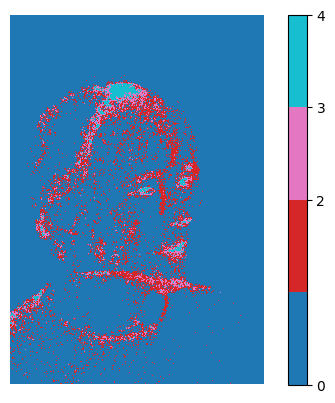

In [3]:
from matplotlib.colors import ListedColormap

features_per_image = {image_id: np.ones([list(images.values())[0].shape[0], list(images.values())[0].shape[1], 1]) * (i+2) for i, image_id in enumerate(list(cam_2_world_poses.keys()))}

gaussian_features = imfp.ImageFeatureProjection.project_features_onto_gaussians(
    gaussian_model=gaussian_model, 
    cam_2_world_poses=cam_2_world_poses, 
    intrinsics=intrinsics, 
    image_height=list(images.values())[0].shape[0], 
    image_width=list(images.values())[0].shape[1],
    features_per_image = features_per_image
)

gaussian_features[gaussian_features==0] = 1

projected_images = imfp.ImageFeatureProjection.project_gaussians_onto_images(
    gaussian_model=gaussian_model, 
    cam_2_world_poses=cam_2_world_poses, 
    intrinsics=intrinsics, 
    image_height=list(images.values())[0].shape[0], 
    image_width=list(images.values())[0].shape[1],
    gaussian_features=gaussian_features
)
    
p = list(projected_images.values())[2]
unique_values = np.unique(p)

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_values)))
cmap = ListedColormap(colors)

plt.imshow(p, cmap=cmap)
plt.colorbar(ticks=unique_values)
plt.axis('off')  # Hide axes
plt.show()

In [4]:
import k3d

colors = [0xffffff, 0x000000, 0xff0000, 0x00ff00, 0x0000ff, 0xffffff]

# Create k3d plot
plot = k3d.plot()
gaussian_feat = gaussian_features.squeeze(1).astype(np.int32)
points = gaussian_model._xyz.detach().cpu().numpy()[:, [0, 2, 1]]
points = -points

# Plot points for each category
for category in np.unique(gaussian_feat):
    if category == 1:
        continue
    indices = np.where(gaussian_feat == category)
    plot += k3d.points(points[indices,:], point_size=0.002, color=colors[category], shader='3d')

plot.display()

Output()